In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd

# 数据预处理

In [2]:
#读取共享单车数据
bikedata = pd.read_csv(r'data/bikedata-sample.csv')
bikedata.head(5)

BIKE_ID           DATA_TIME  LOCK_STATUS   LONGITUDE   LATITUDE
0        5  2018-09-01 0:00:36            1  121.363566  31.259615
1        6  2018-09-01 0:00:50            0  121.406226  31.214436
2        6  2018-09-01 0:03:01            1  121.409402  31.215259
3        6  2018-09-01 0:24:53            0  121.409228  31.214427
4        6  2018-09-01 0:26:38            1  121.409771  31.214406

In [4]:
#读取上海行政区划边界
shanghai_admin = gpd.read_file(r'data/shanghai.json')
#剔除研究范围外的数据
bikedata = tbd.clean_outofshape(bikedata, shanghai_admin, col=['LONGITUDE', 'LATITUDE'], accuracy=500)

In [5]:
#识别单车出行OD
move_data,stop_data = tbd.bikedata_to_od(bikedata,
                   col = ['BIKE_ID','DATA_TIME','LONGITUDE','LATITUDE','LOCK_STATUS'])
move_data.head(5)

BIKE_ID                stime        slon       slat  \
96          6   2018-09-01 0:00:50  121.406226  31.214436   
561         6   2018-09-01 0:24:53  121.409228  31.214427   
564         6   2018-09-01 0:50:16  121.409727  31.214403   
784         6   2018-09-01 0:53:38  121.413333  31.214951   
1028        6  2018-09-01 11:35:01  121.419261  31.213414   

                    etime        elon       elat  
96     2018-09-01 0:03:01  121.409402  31.215259  
561    2018-09-01 0:26:38  121.409771  31.214406  
564    2018-09-01 0:52:14  121.412610  31.214905  
784    2018-09-01 0:55:38  121.412656  31.217051  
1028  2018-09-01 11:35:13  121.419518  31.213657

In [6]:
#计算骑行直线距离
move_data['distance'] = tbd.getdistance(move_data['slon'],move_data['slat'],move_data['elon'],move_data['elat'])
#清洗骑行数据，删除过长与过短的出行
move_data = move_data[(move_data['distance']>100)&(move_data['distance']<10000)]

In [7]:
# 获取栅格划分参数
bounds = (120.85, 30.67, 122.24, 31.87)
params = tbd.grid_params(bounds,accuracy = 500)
#集计OD
od_gdf = tbd.odagg_grid(move_data, params, col=['slon', 'slat', 'elon', 'elat'])
od_gdf.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


SLONCOL  SLATCOL  ELONCOL  ELATCOL  count      SHBLON     SHBLAT  \
0           26       95       26       96      1  120.986782  31.097177   
40803      117      129      116      127      1  121.465519  31.250062   
40807      117      129      117      128      1  121.465519  31.250062   
40810      117      129      117      131      1  121.465519  31.250062   
40811      117      129      118      126      1  121.465519  31.250062   

           EHBLON     EHBLAT  \
0      120.986782  31.101674   
40803  121.460258  31.241069   
40807  121.465519  31.245565   
40810  121.465519  31.259055   
40811  121.470780  31.236572   

                                                geometry  
0      LINESTRING (120.98678 31.09718, 120.98678 31.1...  
40803  LINESTRING (121.46552 31.25006, 121.46026 31.2...  
40807  LINESTRING (121.46552 31.25006, 121.46552 31.2...  
40810  LINESTRING (121.46552 31.25006, 121.46552 31.2...  
40811  LINESTRING (121.46552 31.25006, 121.47078 31.2...

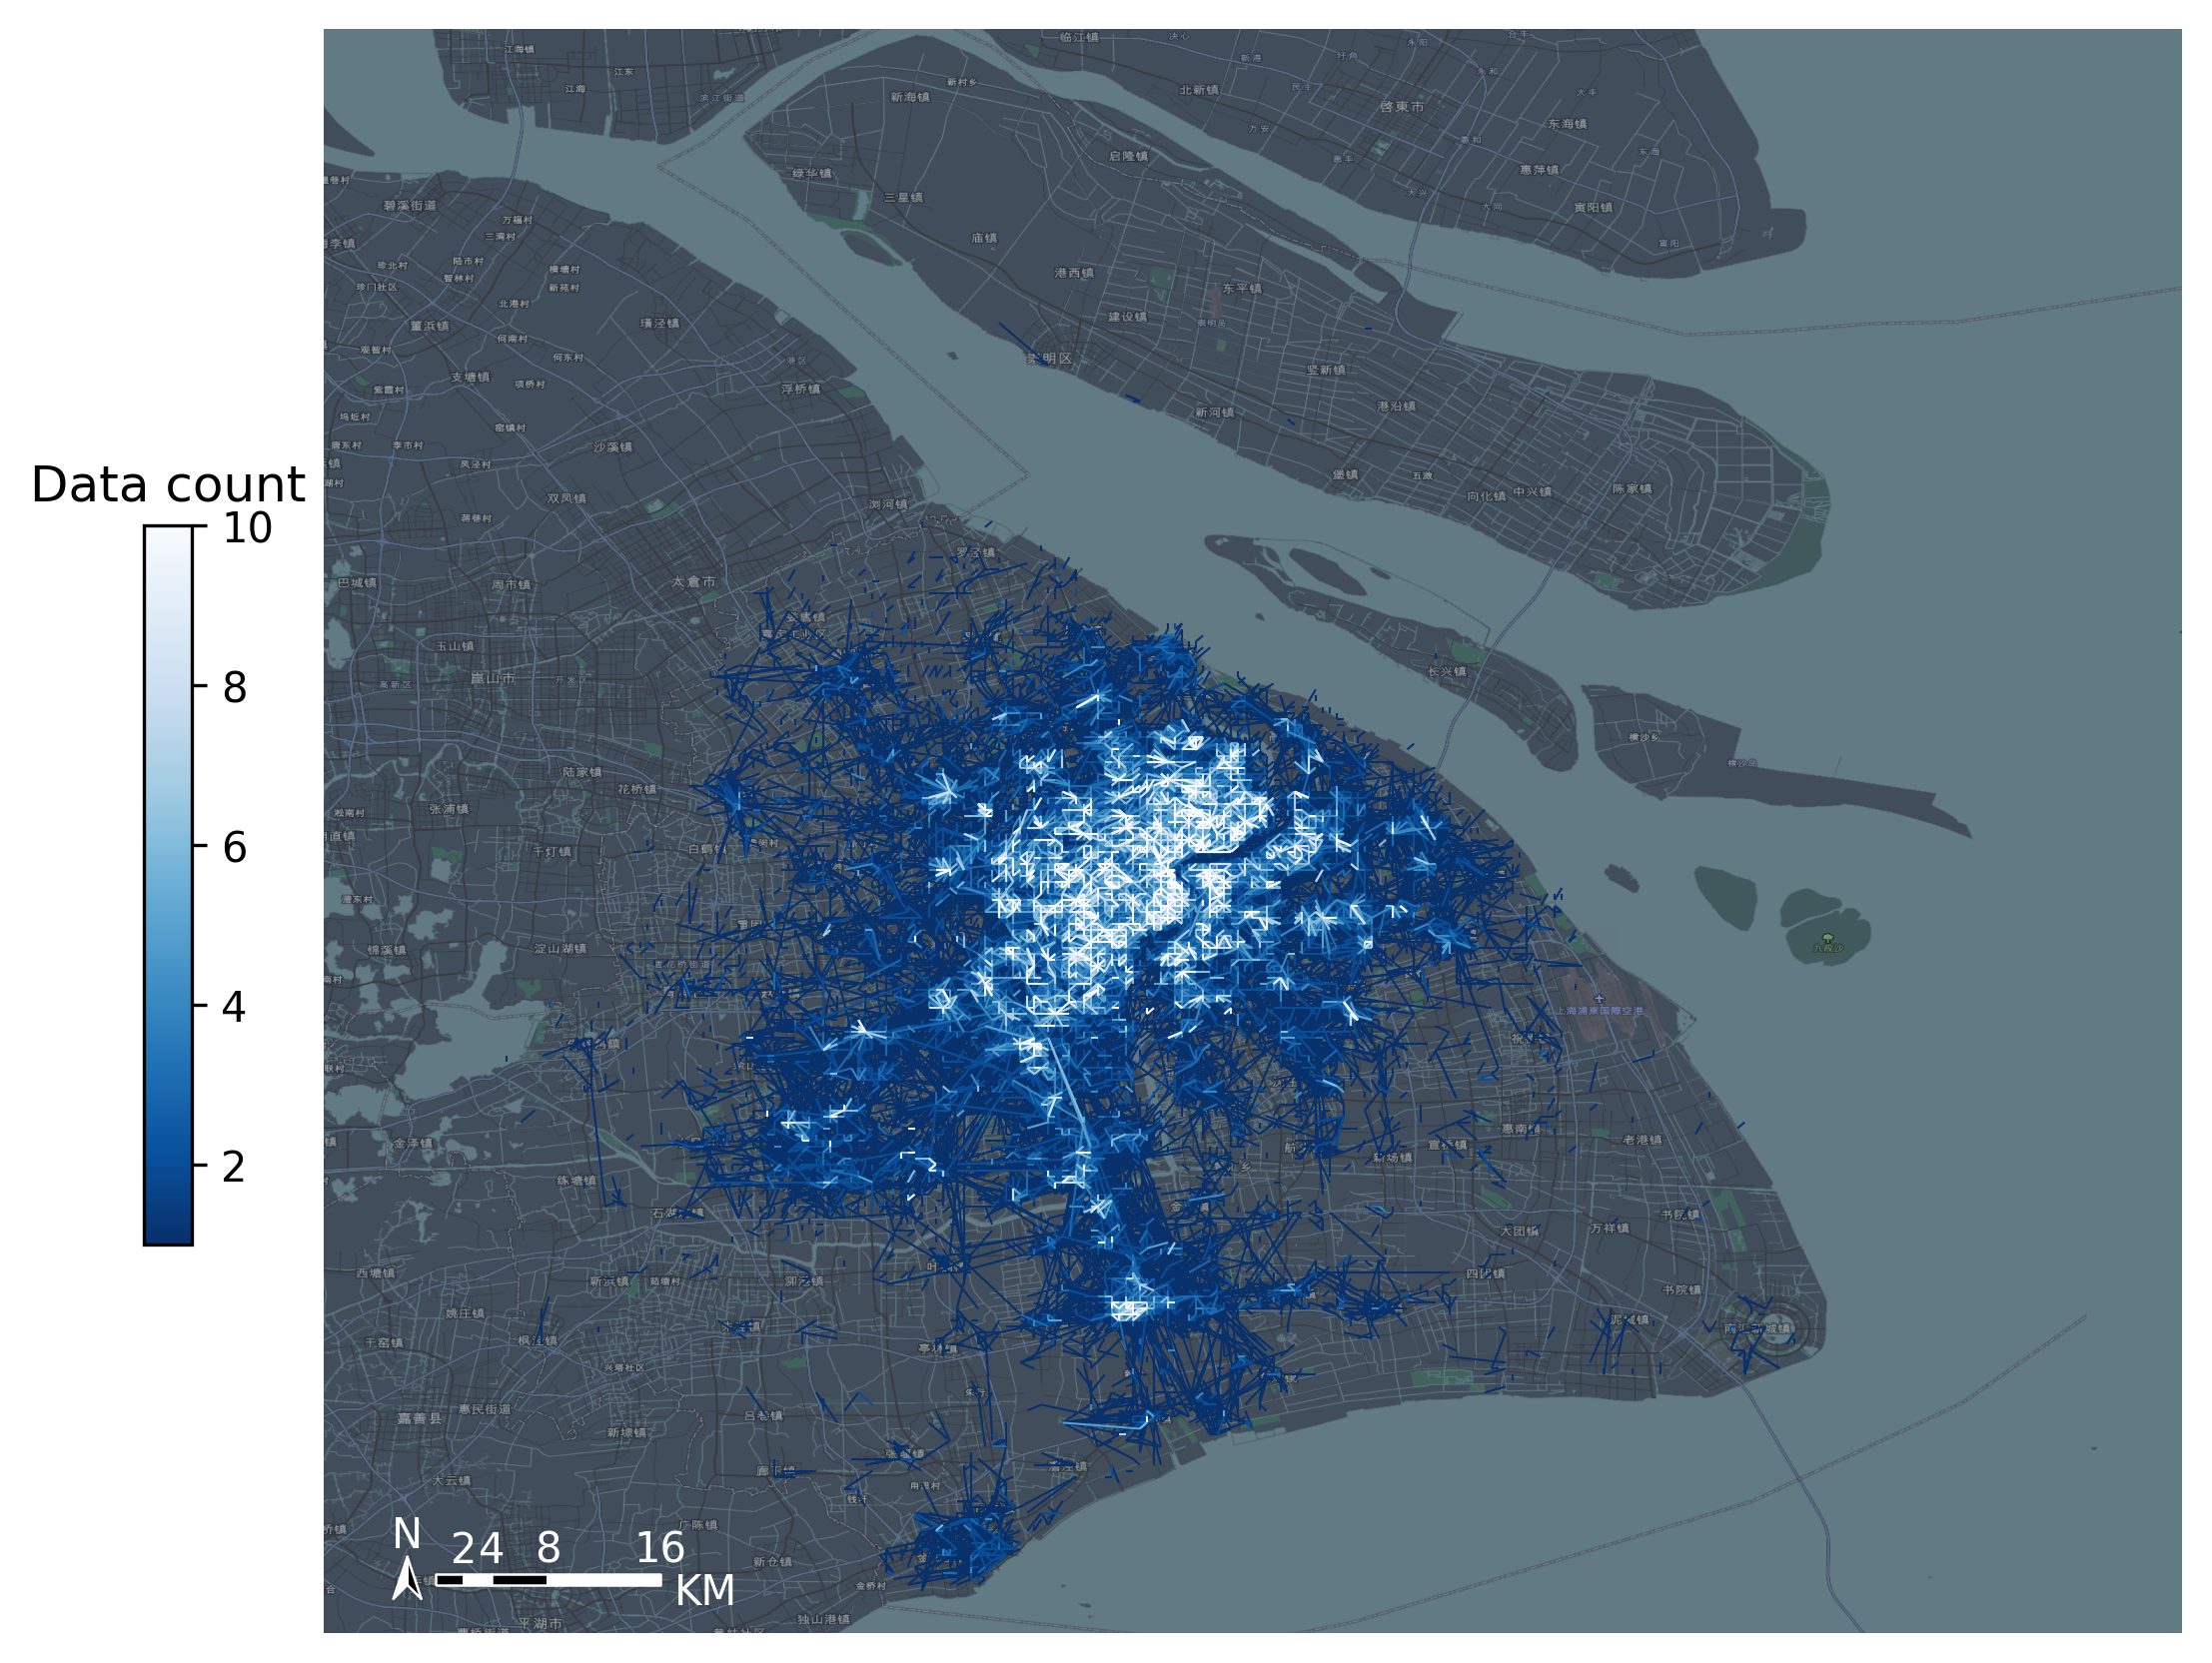

In [10]:
#创建图框
import matplotlib.pyplot as plt
import plot_map
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)
#添加地图底图
tbd.plot_map(plt,bounds,zoom = 11,style = 8)
#绘制colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('Data count')
plt.sca(ax)
#绘制OD
od_gdf.plot(ax = ax,column = 'count',cmap = 'Blues_r',linewidth = 0.5,vmax = 10,cax = cax,legend = True)
#添加比例尺和指北针
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,textcolor = 'white',accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

# 网络构建

## 提取节点信息

In [11]:
#把起终点的经纬度栅格编号变为一个字段
od_gdf['S'] = od_gdf['SLONCOL'].astype(str) + ',' + od_gdf['SLATCOL'].astype(str)
od_gdf['E'] = od_gdf['ELONCOL'].astype(str) + ',' + od_gdf['ELATCOL'].astype(str)
#提取节点集合
node = set(od_gdf['S'])|set(od_gdf['E'])
#把节点集合变成DataFrame
node = pd.DataFrame(node)
#重新编号节点
node['id'] = range(len(node))
node

0    id
0     118,134     0
1     109,102     1
2       59,71     2
3       93,78     3
4       96,17     4
...       ...   ...
9806    94,97  9806
9807  106,152  9807
9808  124,134  9808
9809   98,158  9809
9810   152,86  9810

[9811 rows x 2 columns]

## 提取边信息

In [12]:
#把新编号连接到OD数据上
node.columns = ['S','S_id']
od_gdf = pd.merge(od_gdf,node,on = ['S'])
node.columns = ['E','E_id']
od_gdf = pd.merge(od_gdf,node,on = ['E'])
#提取边信息
edge = od_gdf[['S_id','E_id','count']]
edge

S_id  E_id  count
0      8261  7105      1
1      9513  2509      1
2       118  2509      3
3       348  2509      1
4      1684  2509      1
...     ...   ...    ...
68468  8024  4490      2
68469  4216  3802      2
68470  4786  6654      2
68471  6484   602      3
68472  7867  8270      3

[68473 rows x 3 columns]

## 构建网络

In [13]:
import igraph
#创建网络
g = igraph.Graph()
#在网络中添加节点。
g.add_vertices(len(node))
#在网络中添加边。
g.add_edges(edge[['S_id','E_id']].values)
#提取边的权重。
edge_weights = edge[['count']].values
#给边添加权重。
for i in range(len(edge_weights)):
    g.es[i]['weight'] = edge_weights[i]

# 社区发现

In [14]:
#社区发现
g_clustered = g.community_multilevel(weights = edge_weights, return_levels=False)

In [15]:
#模块度
g_clustered.modularity

0.8496561130926571

In [16]:
#将结果赋值到节点上
node['group'] = g_clustered.membership
#重命名列
node.columns = ['grid','node_id','group']
node

grid  node_id  group
0     118,134        0      0
1     109,102        1      1
2       59,71        2      2
3       93,78        3      3
4       96,17        4      4
...       ...      ...    ...
9806    94,97     9806      8
9807  106,152     9807     36
9808  124,134     9808     37
9809   98,158     9809      9
9810   152,86     9810     26

[9811 rows x 3 columns]

# 社区可视化

In [17]:
#统计每个社区的栅格数量
group = node['group'].value_counts()
#提取大于10个栅格的社区
group = group[group>10]
#只保留这些社区的栅格
node = node[node['group'].apply(lambda r:r in group.index)]

In [18]:
#切分获取栅格编号
node['LONCOL'] = node['grid'].apply(lambda r:r.split(',')[0]).astype(int)
node['LATCOL'] = node['grid'].apply(lambda r:r.split(',')[1]).astype(int)
#生成栅格地理图形
node['geometry'] = tbd.gridid_to_polygon(node['LONCOL'],node['LATCOL'],params)
#转为GeoDataFrame
import geopandas as gpd
node = gpd.GeoDataFrame(node)
node

<ipython-input-18-a40a53cc2e76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node['LONCOL'] = node['grid'].apply(lambda r:r.split(',')[0]).astype(int)
<ipython-input-18-a40a53cc2e76>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node['LATCOL'] = node['grid'].apply(lambda r:r.split(',')[1]).astype(int)
<ipython-input-18-a40a53cc2e76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

grid  node_id  group  LONCOL  LATCOL  \
0     118,134        0      0     118     134   
1     109,102        1      1     109     102   
3       93,78        3      3      93      78   
4       96,17        4      4      96      17   
5     156,117        5      5     156     117   
...       ...      ...    ...     ...     ...   
9806    94,97     9806      8      94      97   
9807  106,152     9807     36     106     152   
9808  124,134     9808     37     124     134   
9809   98,158     9809      9      98     158   
9810   152,86     9810     26     152      86   

                                               geometry  
0     POLYGON ((121.46815 31.27030, 121.47341 31.270...  
1     POLYGON ((121.42080 31.12641, 121.42606 31.126...  
3     POLYGON ((121.33663 31.01849, 121.34189 31.018...  
4     POLYGON ((121.35241 30.74419, 121.35767 30.744...  
5     POLYGON ((121.66806 31.19385, 121.67332 31.193...  
...                                                 ...  
9806  POLYGON ((121.34189 31.10392, 121.34715 31.103...  
9807  POLYGON ((121.40502 31.35124, 121.41028 31.351...  
9808  POLYGON ((121.49971 31.27030, 121.50498 31.270...  
9809  POLYGON ((121.36293 31.37822, 121.36819 31.378...  
9810  POLYGON ((121.64702 31.05446, 121.65228 31.054...  

[8527 rows x 6 columns]

<AxesSubplot:>

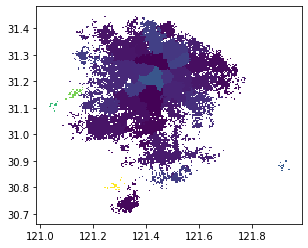

In [19]:
node.plot('group')

In [20]:
#以group字段为分组，将同一组别的面要素合并
node_community = tbd.merge_polygon(node,'group')
#输入多边形GeoDataFrame数据，对多边形取外边界构成新多边形
#设定最小面积minarea，小于该面积的面全部剔除，避免大量离群点出现
node_community = tbd.polyon_exterior(node_community,minarea = 0.000100)

/opt/anaconda3/lib/python3.8/site-packages/transbigdata/gisprocess.py:208: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for i in p:


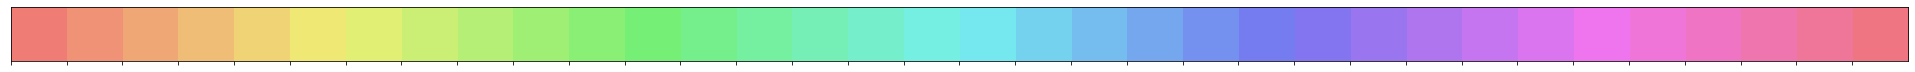

In [21]:
#生成调色盘
import seaborn as sns
## l: 亮度
## s: 饱和度
cmap = sns.hls_palette(n_colors=len(node_community), l=.7, s=0.8)
sns.palplot(cmap)

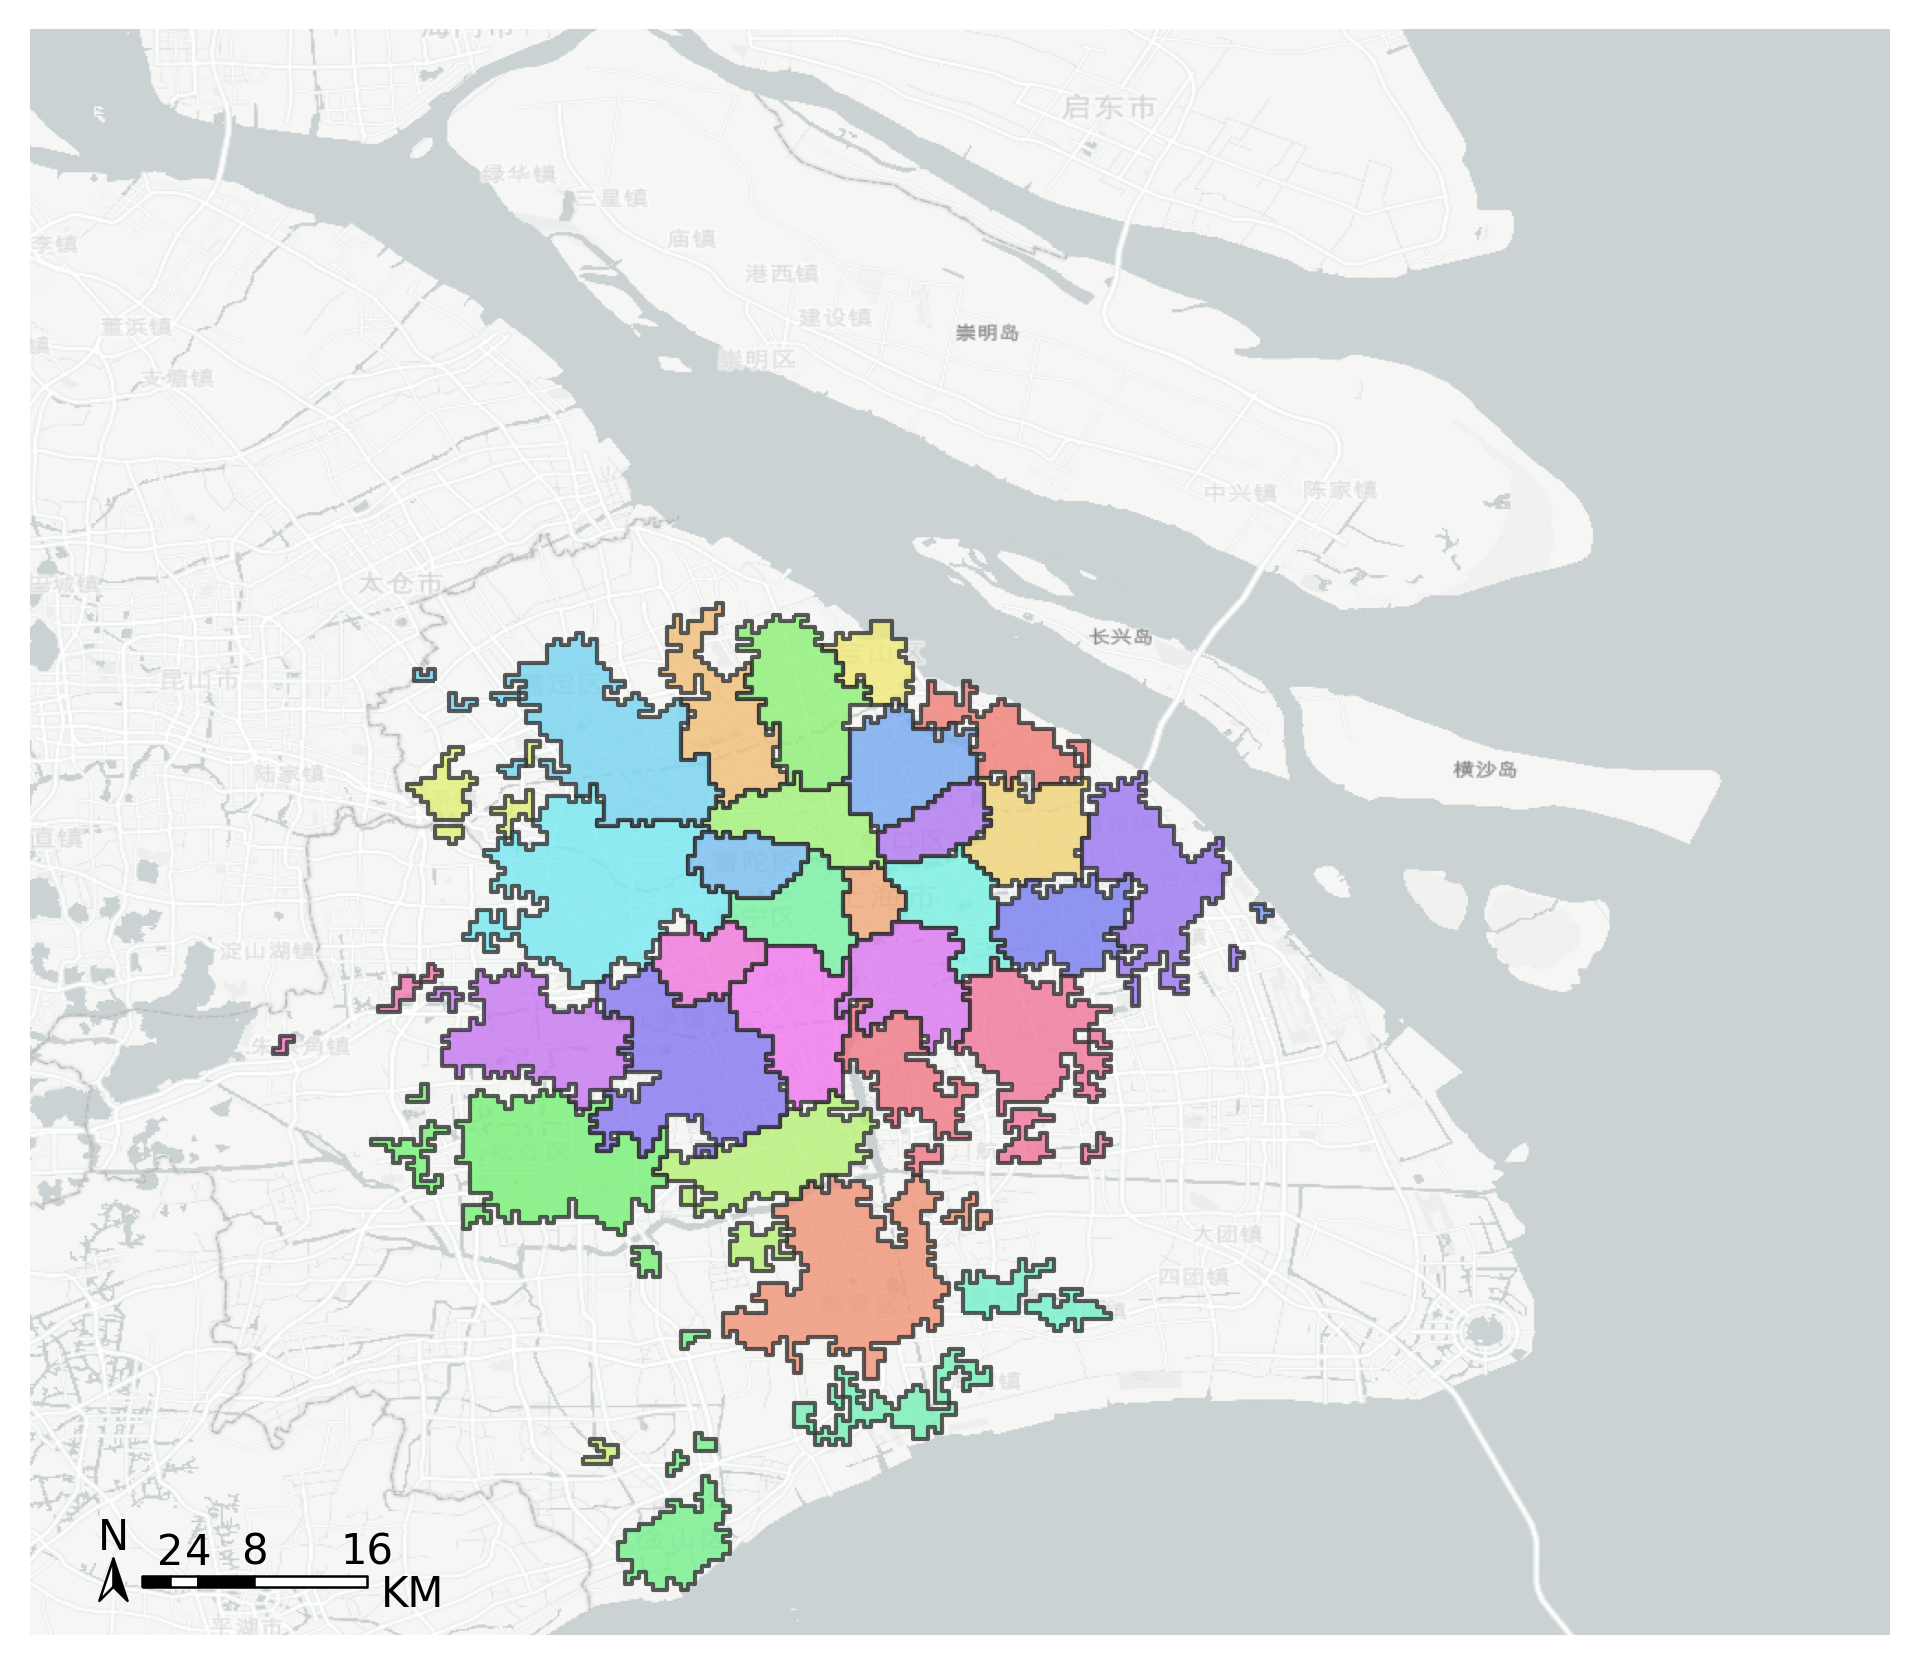

In [22]:
#创建图框
import matplotlib.pyplot as plt
import plot_map
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)
#添加地图底图
tbd.plot_map(plt,bounds,zoom = 10,style = 6)
#设定colormap
from matplotlib.colors import ListedColormap 
#打乱社区的排列顺序
node_community = node_community.sample(frac=1)
#绘制社区
node_community.plot(cmap = ListedColormap(cmap),ax = ax,edgecolor = '#333',alpha = 0.8)
#添加比例尺和指北针
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,textcolor = 'k'
              ,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()